## Разработать модель(и) машинного обучения для прогнозирования ежедневного GMV (Gross Merchandise Value) и количества заказов на 7 дней вперед. Оценка качества прогнозов на основе MAPE

## Что нужно сделать:
* Исследовательский анализ данных (EDA).
* Подготовка данных и генерация признаков (Feature Engineering).
* Выбор и обучение модели.
* Оценка качества прогнозов.

### Исследовательский анализ данных (EDA)

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [52]:
df = pd.read_csv('../data/daily_sales_metrics.csv', parse_dates=['date'])
df

,date,gmv,orders,sessions,marketing_spend,is_promo_active,day_of_week,day_of_year,week_of_year,month,year
0,2022-01-01,506994,1081,34861,25148,0,5,1,52,1,2022
1,2022-01-02,445834,819,32858,23769,0,6,2,52,1,2022
2,2022-01-03,348150,736,23081,22108,0,0,3,1,1,2022
3,2022-01-04,359418,872,25166,21757,0,1,4,1,1,2022
4,2022-01-05,381439,871,31082,21420,0,2,5,1,1,2022
...,...,...,...,...,...,...,...,...,...,...,...
1090,2024-12-26,891794,5410,171515,54332,0,3,361,52,12,2024
1091,2024-12-27,1011484,6330,219724,55346,0,4,362,52,12,2024
1092,2024-12-28,1064332,6767,229631,56839,0,5,363,52,12,2024
1093,2024-12-29,1150266,6829,223812,75393,1,6,364,52,12,2024


## Проверим типы и целостность данных

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             1095 non-null   datetime64[ns]
 1   gmv              1095 non-null   int64         
 2   orders           1095 non-null   int64         
 3   sessions         1095 non-null   int64         
 4   marketing_spend  1095 non-null   int64         
 5   is_promo_active  1095 non-null   int64         
 6   day_of_week      1095 non-null   int64         
 7   day_of_year      1095 non-null   int64         
 8   week_of_year     1095 non-null   int64         
 9   month            1095 non-null   int64         
 10  year             1095 non-null   int64         
dtypes: datetime64[ns](1), int64(10)
memory usage: 94.2 KB


In [54]:
df.isna().sum()

date               0
gmv                0
orders             0
sessions           0
marketing_spend    0
is_promo_active    0
day_of_week        0
day_of_year        0
week_of_year       0
month              0
year               0
dtype: int64

In [55]:
df.duplicated().sum()

np.int64(0)

## Спустя день работы я узнал, что есть готовые модули для разложения ряда на тренды и сезонность. Я посмотрел, вроде результат тот же, что моими "ручными" методами. Если успею или результат будет плохой, переделаю по-человечески

## Построим графики для выявления сезонности

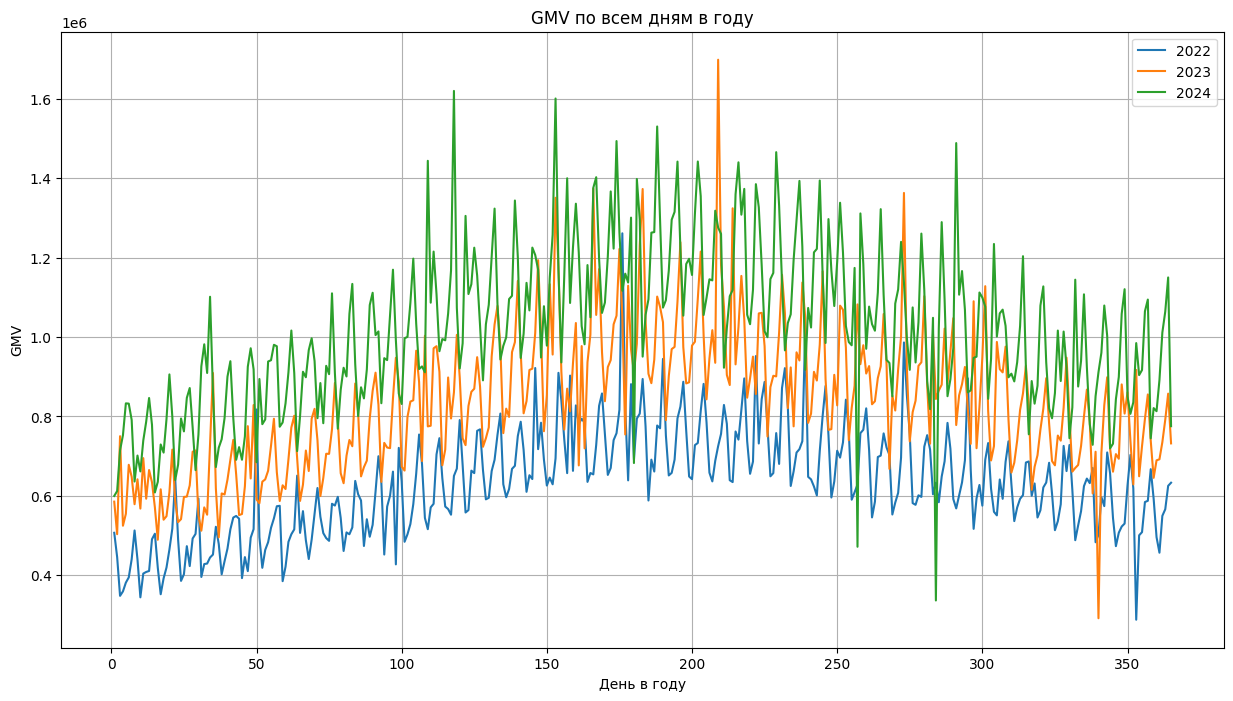

In [56]:
years = (2022, 2023, 2024)

plt.figure(figsize=(15, 8))

for year in years:
    sub = df[df.year == year]
    plt.plot(
        sub.day_of_year,
        sub.gmv,
        label=year
    )

plt.title('GMV по всем дням в году')
plt.xlabel('День в году')
plt.ylabel('GMV')
plt.legend()
plt.grid()
plt.show()

## С учётом крупных промо-акций

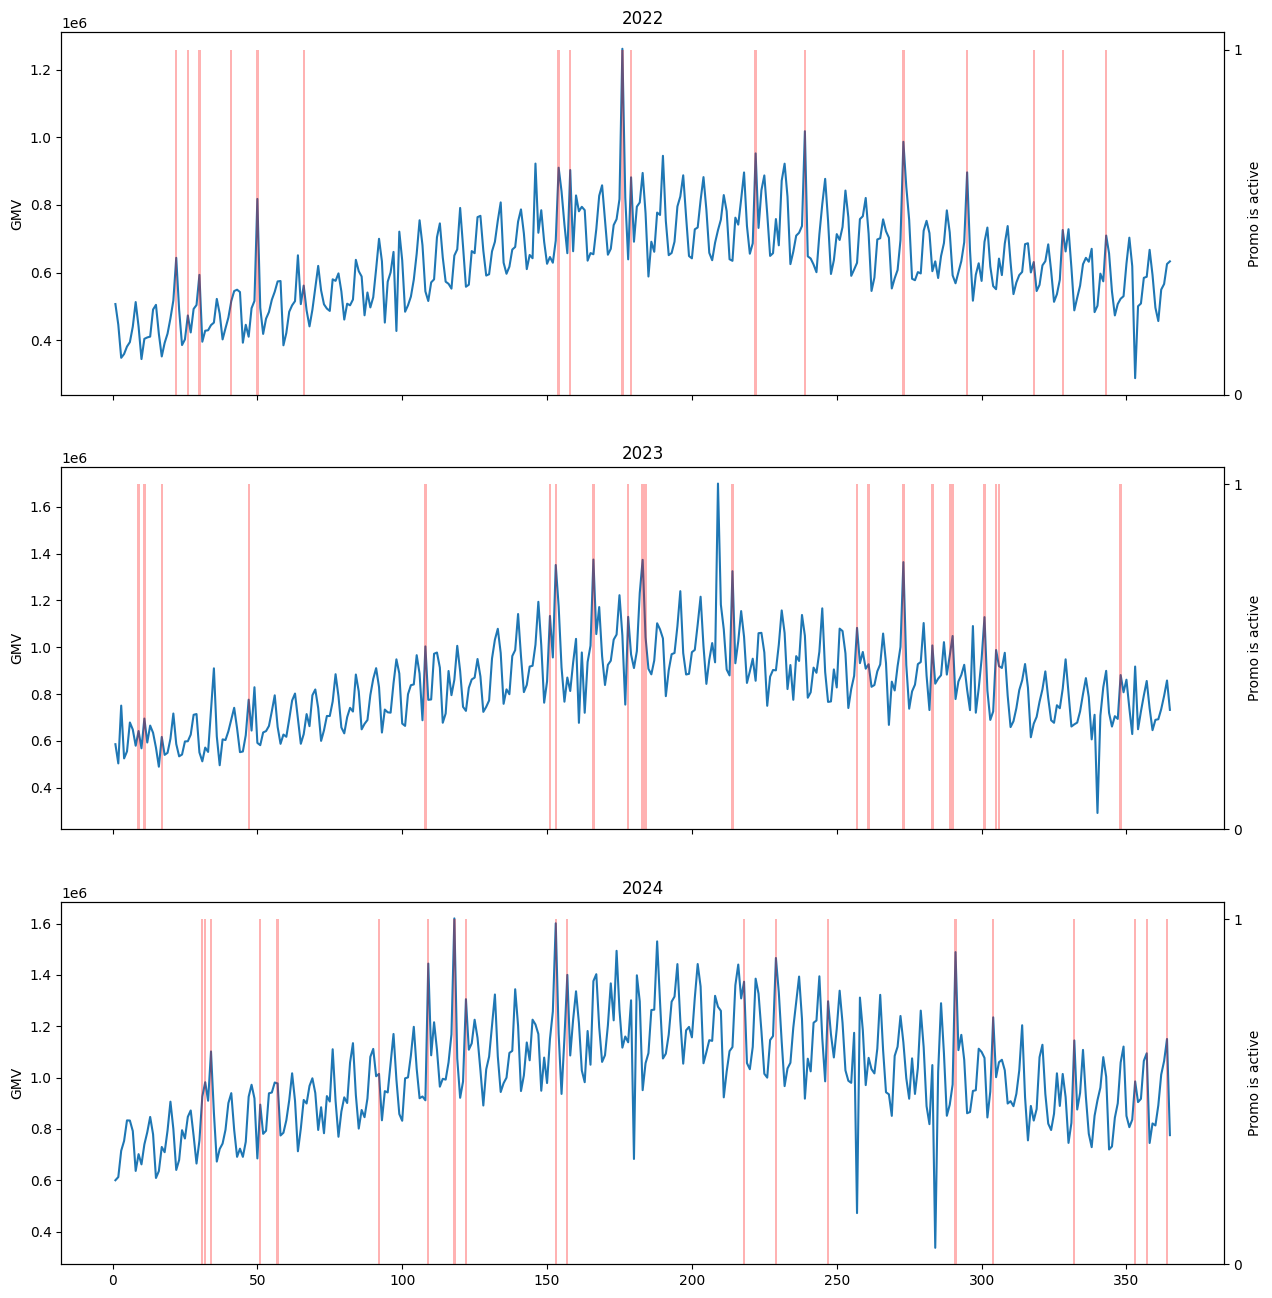

In [57]:
fig, axes = plt.subplots(3, 1, figsize=(15, 16), sharex=True)

for i, year in enumerate(years):
    ax = axes[i]
    sub = df[df.year == year]
    
    ax.plot(
        sub.day_of_year,
        sub.gmv,
    )
    ax.set_title(year)
    ax.set_ylabel('GMV')
    
    ax2 = ax.twinx()
    ax2.bar(
        sub.day_of_year,
        sub.is_promo_active,
        alpha=0.3,
        color='red',
    )
    ax2.set_ylabel('Promo is active')
    ax2.set_yticks([0, 1])

plt.xlabel('День в году')
plt.show()

## С учётом масштабов промо

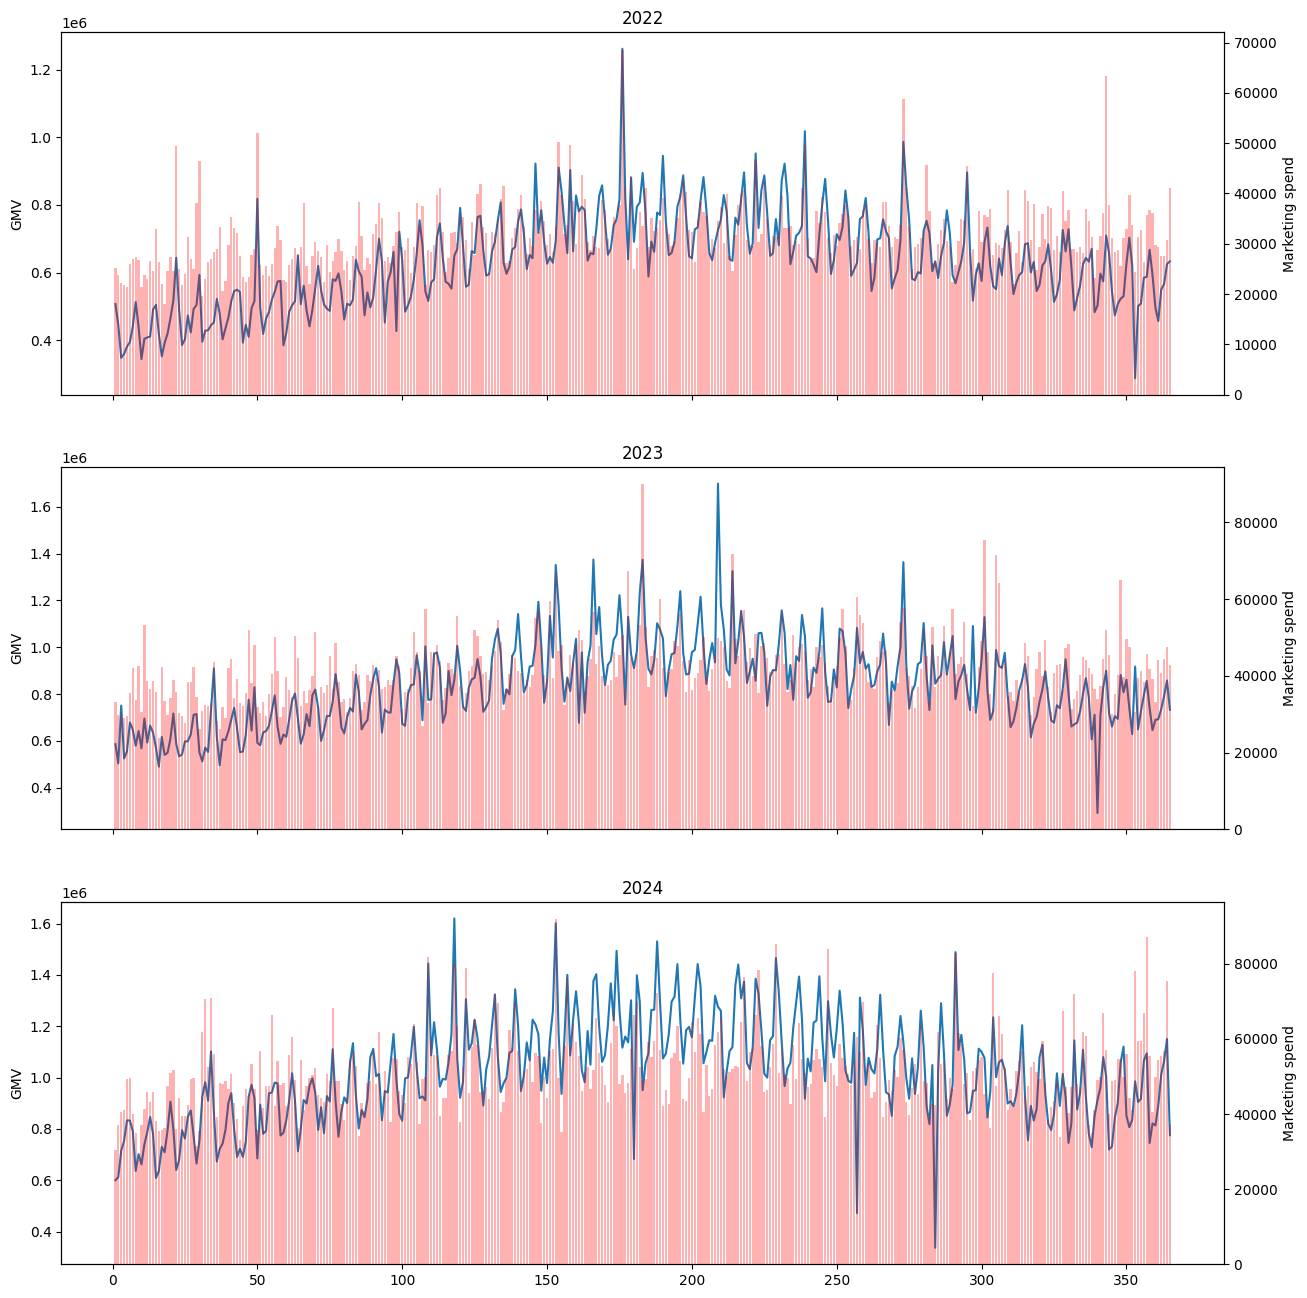

In [61]:
fig, axes = plt.subplots(3, 1, figsize=(15, 16), sharex=True)

for i, year in enumerate(years):
    ax = axes[i]
    sub = df[df.year == year]
    
    ax.plot(
        sub.day_of_year,
        sub.gmv,
    )
    ax.set_title(year)
    ax.set_ylabel('GMV')
    
    ax2 = ax.twinx()
    ax2.bar(
        sub.day_of_year,
        sub.marketing_spend,
        alpha=0.3,
        color='red',
    )
    ax2.set_ylabel('Marketing spend')

plt.xlabel('День в году')
plt.show()

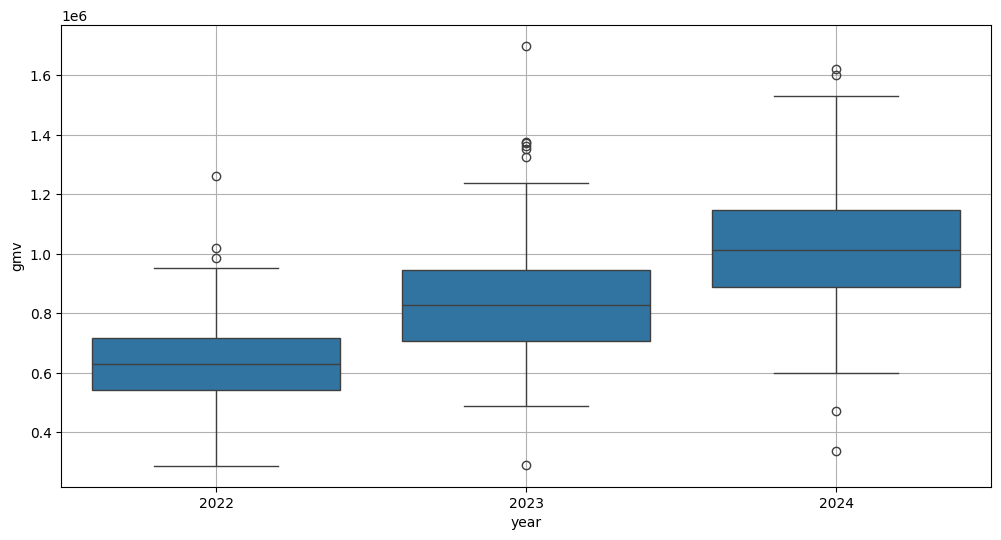

In [63]:
plt.figure(figsize=(12, 6))

sns.boxplot(
    data=df,
    x='year',
    y='gmv',
)

plt.grid()

## Есть выбросы, надо проверить, не из-за крупных скидок ли они появились

In [64]:
q1 = df.groupby('year')['gmv'].transform(lambda x: x.quantile(0.25))
q3 = df.groupby('year')['gmv'].transform(lambda x: x.quantile(0.75))
iqr = q3 - q1

df['is_outlier'] = (
    (df['gmv'] < q1 - 1.5 * iqr) |
    (df['gmv'] > q3 + 1.5 * iqr)
)

In [65]:
pd.crosstab(df['is_promo_active'], df['is_outlier'])

is_outlier,False,True
is_promo_active,,
0,1032,4
1,49,10


## Имеется 4 Выброса в дни с неактивным промо. Возможно, была активная маркетинговая компания

In [66]:
df[(df['is_outlier'] == True) & (df['is_promo_active'] == 0)]

,date,gmv,orders,sessions,marketing_spend,is_promo_active,day_of_week,day_of_year,week_of_year,month,year,is_outlier
573,2023-07-28,1698764,5561,195556,49875,0,4,209,30,7,2023,True
704,2023-12-06,291745,2828,95025,33876,0,2,340,49,12,2023,True
986,2024-09-13,471804,4344,175892,60606,0,4,257,37,9,2024,True
1013,2024-10-10,336499,4111,127137,42468,0,3,284,41,10,2024,True


## Последние три выброса не получается обосновать ни маркетингом, ни промо, ни сезонностью (в 2022 и 2023 под конец года были резкие падения gmv, но разброс дат большеват для сезонности, да и в 2024 году выбросы вниз происходят далеко в других датах, так что лучше их, всё-таки, удалить)

## Сумасшедший скачок gmv в 2023 тоже не обоснован выше упомянутыми критериями, от него тоже избавимся

In [67]:
index_to_drop = df[(df['is_outlier'] == True) & (df['is_promo_active'] == 0)].index
df.drop(index=index_to_drop, inplace=True)

## Выбросы в дни с промо-акцией оставим, так как они имеют и приемлимую маректинговую кампанию, и полезную информацию в виде обоснованных скачков

In [68]:
df.loc[
    df['is_promo_active'] == 1,
    'is_outlier'
] = False

## Проанализируем количество заказов

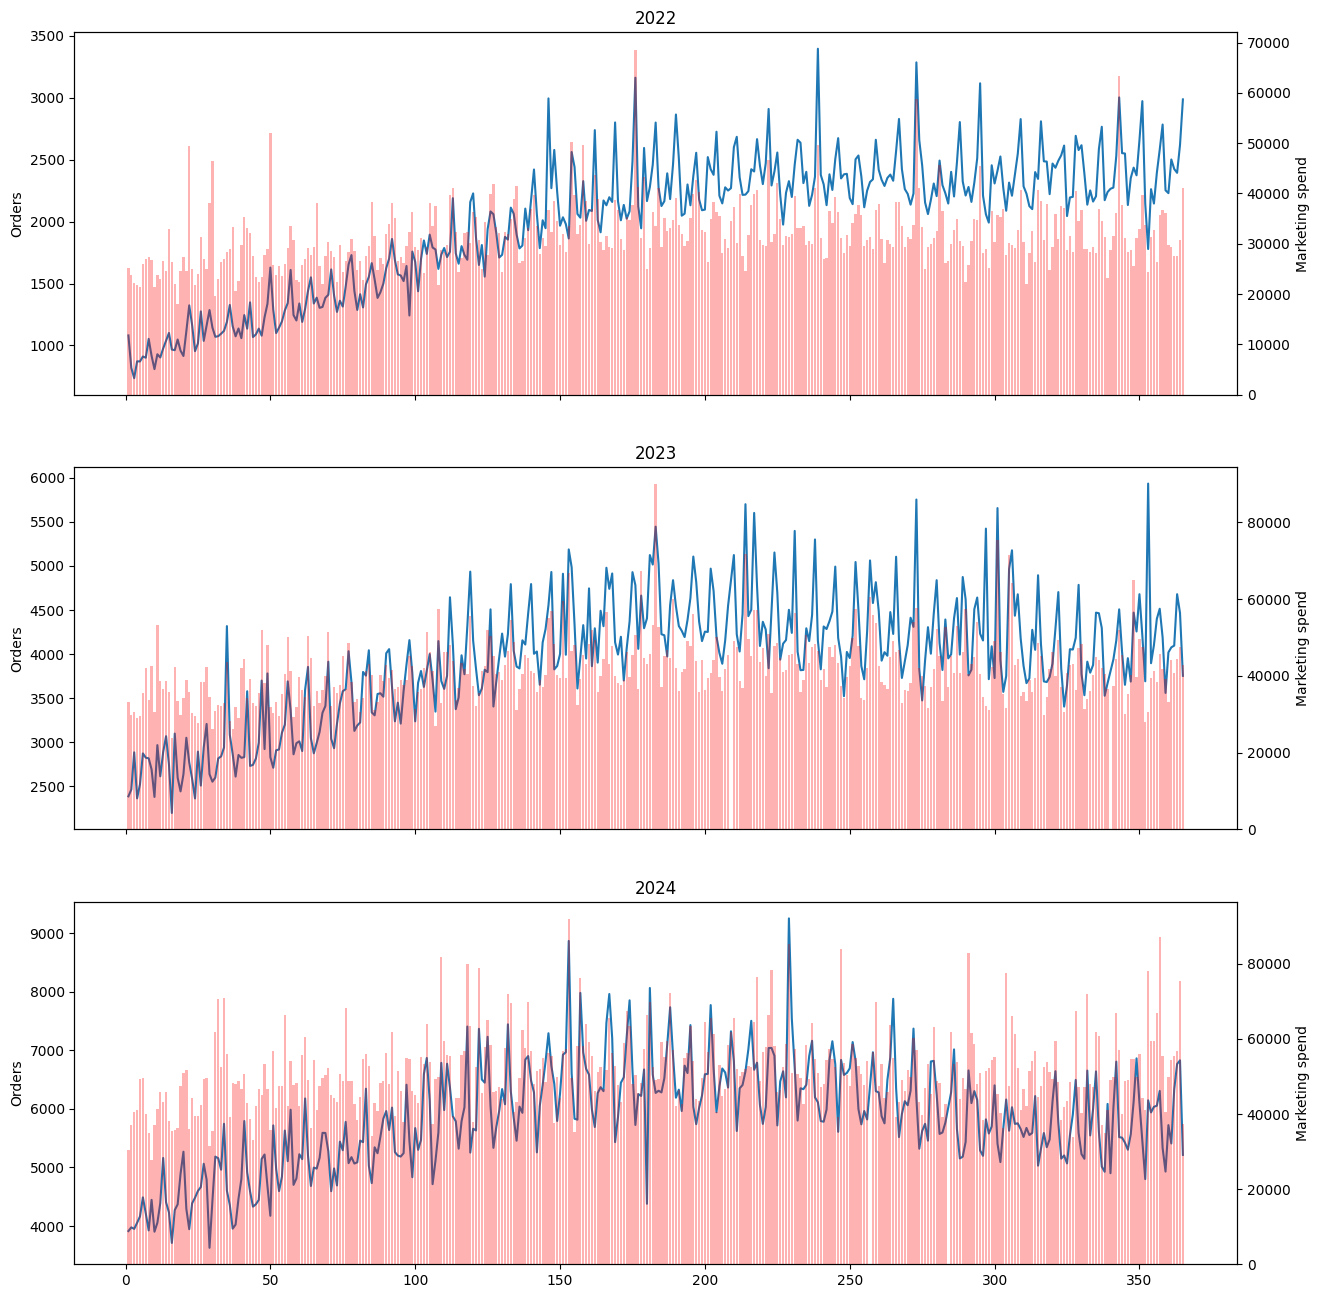

In [69]:
fig, axes = plt.subplots(3, 1, figsize=(15, 16), sharex=True)

for i, year in enumerate(years):
    ax = axes[i]
    sub = df[df.year == year]
    
    ax.plot(
        sub.day_of_year,
        sub.orders,
    )
    ax.set_title(year)
    ax.set_ylabel('Orders')
    
    ax2 = ax.twinx()
    ax2.bar(
        sub.day_of_year,
        sub.marketing_spend,
        alpha=0.3,
        color='red',
    )
    ax2.set_ylabel('Marketing spend')

plt.xlabel('День в году')
plt.show()

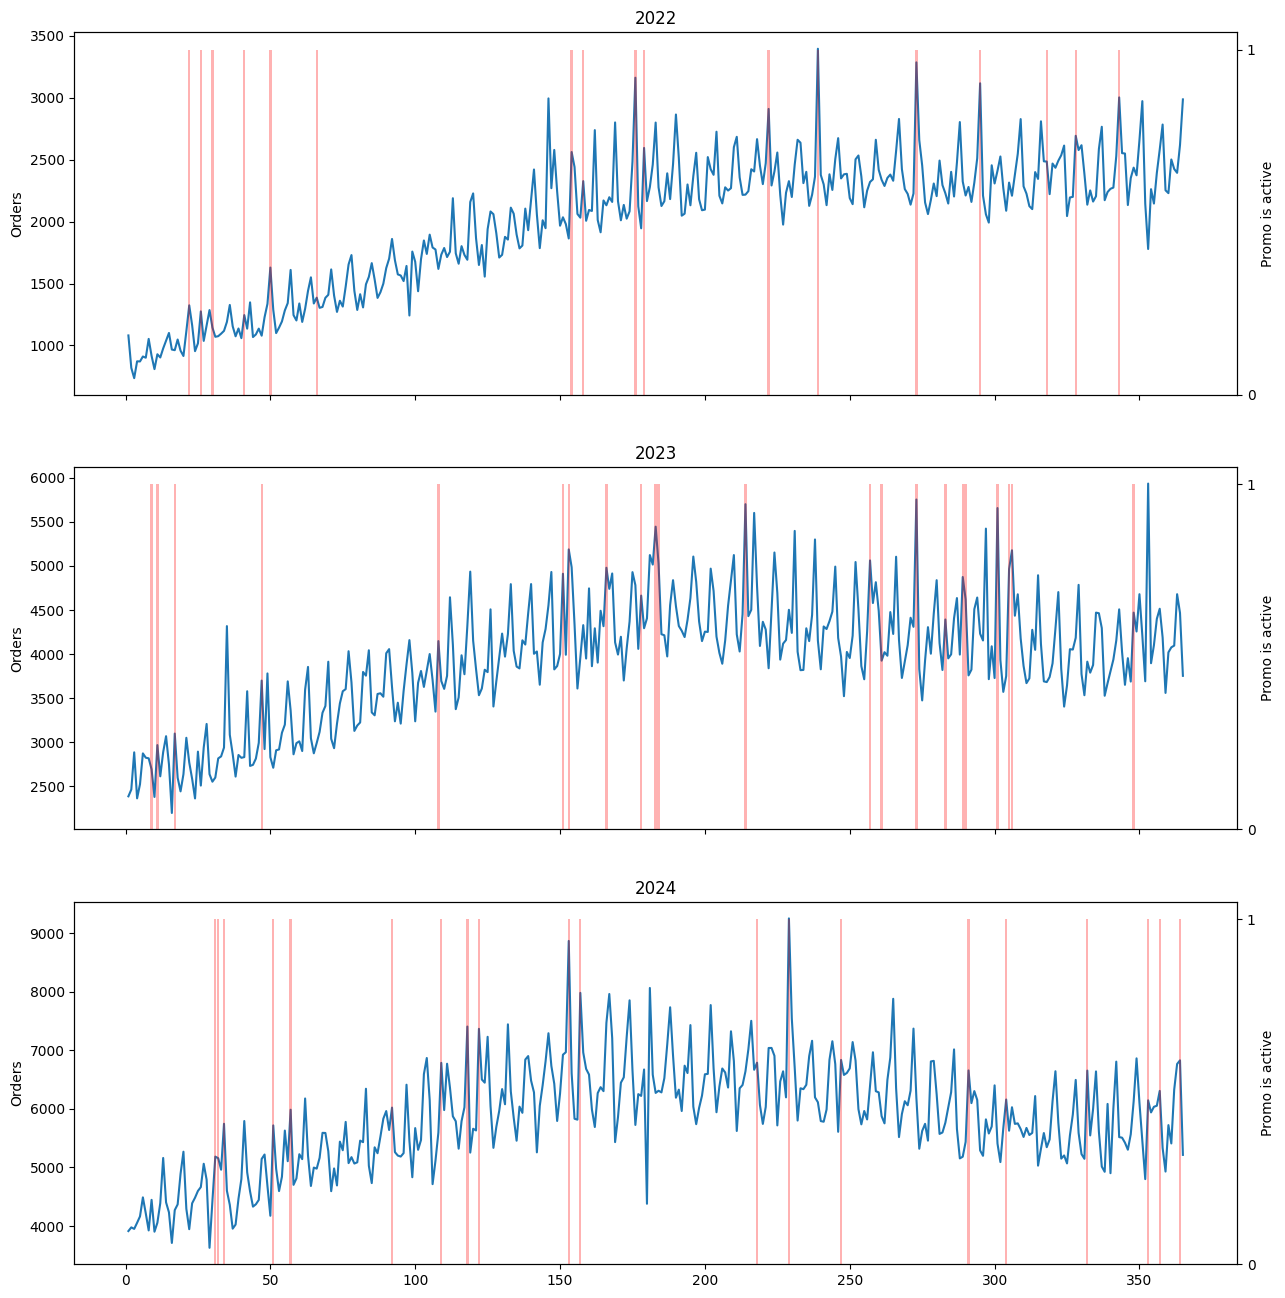

In [70]:
fig, axes = plt.subplots(3, 1, figsize=(15, 16), sharex=True)

for i, year in enumerate(years):
    ax = axes[i]
    sub = df[df.year == year]
    
    ax.plot(
        sub.day_of_year,
        sub.orders,
    )
    ax.set_title(year)
    ax.set_ylabel('Orders')
    
    ax2 = ax.twinx()
    ax2.bar(
        sub.day_of_year,
        sub.is_promo_active,
        alpha=0.3,
        color='red',
    )
    ax2.set_ylabel('Promo is active')
    ax2.set_yticks([0, 1])

plt.xlabel('День в году')
plt.show()

## Имеем воходящий тренд, по которому трудно статистическими методами выявлять выбросы, поэтому детрендируем его

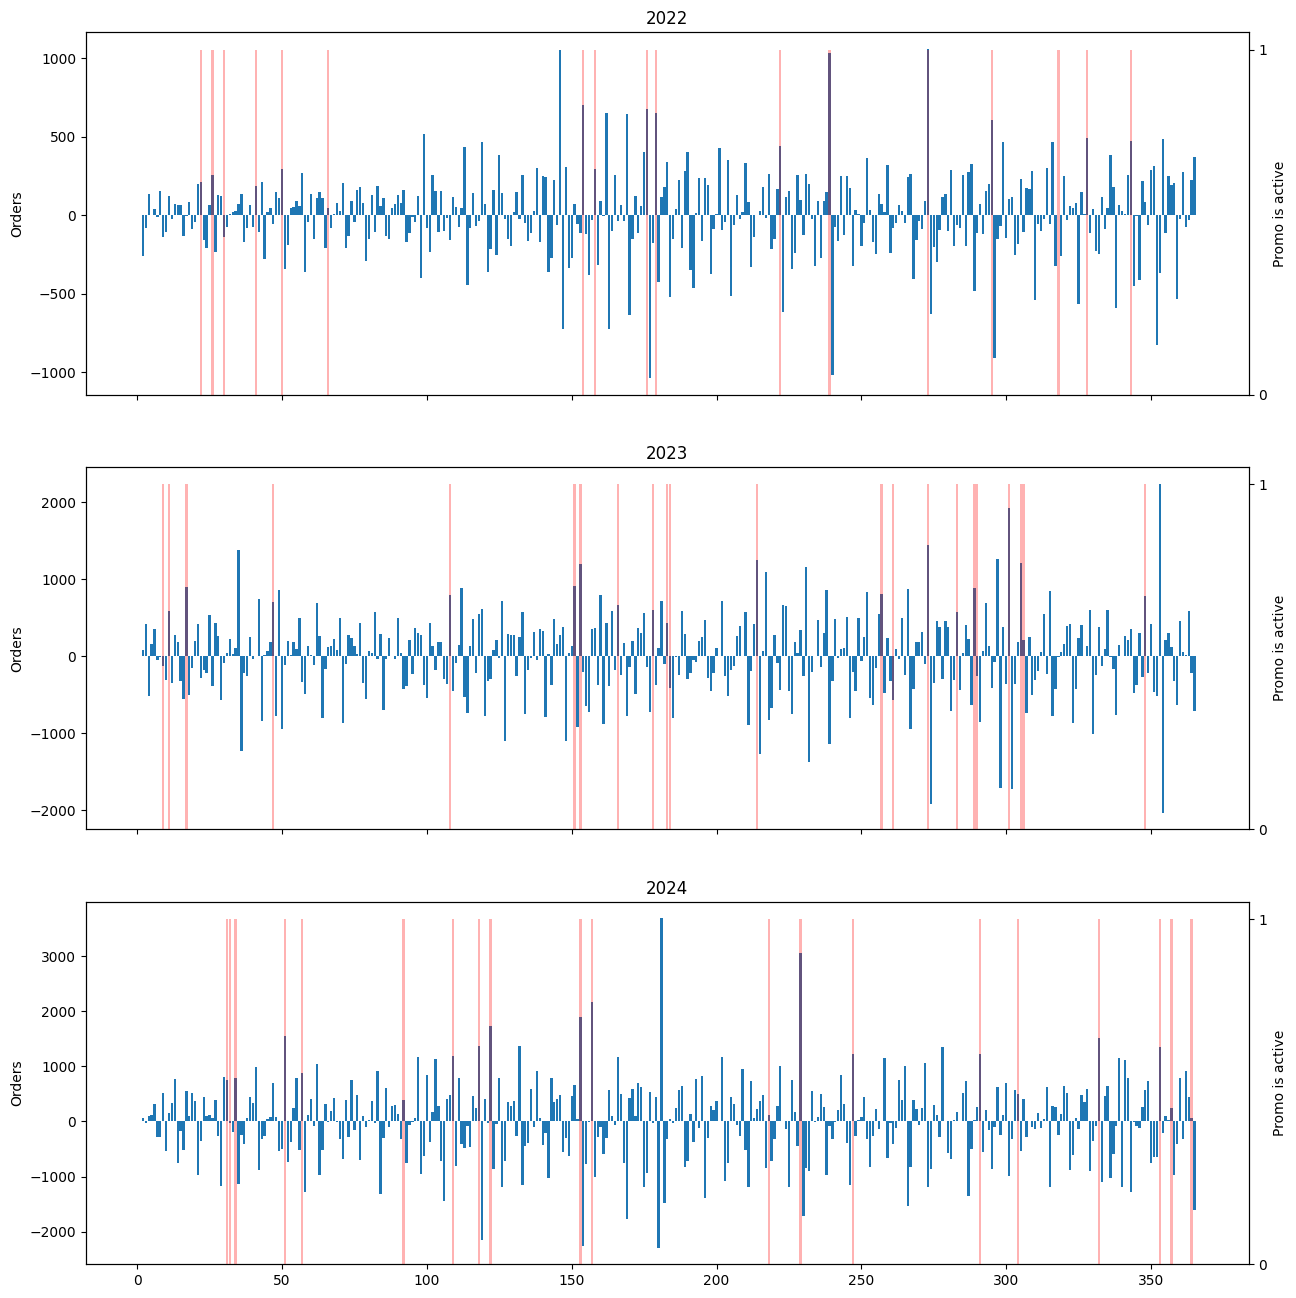

In [18]:
fig, axes = plt.subplots(3, 1, figsize=(15, 16), sharex=True)

for i, year in enumerate(years):
    ax = axes[i]
    sub = df[df.year == year]
    
    ax.bar(
        sub.day_of_year,
        sub.orders.diff(),
    )
    ax.set_title(year)
    ax.set_ylabel('Orders')
    
    ax2 = ax.twinx()
    ax2.bar(
        sub.day_of_year,
        sub.is_promo_active,
        alpha=0.3,
        color='red',
    )
    ax2.set_ylabel('Promo is active')
    ax2.set_yticks([0, 1])

plt.xlabel('День в году')
plt.show()

In [71]:
detrended = df.copy()
detrended['orders'] = detrended['orders'].diff()

q1 = detrended.groupby('year')['orders'].transform(lambda x: x.quantile(0.25))
q3 = detrended.groupby('year')['orders'].transform(lambda x: x.quantile(0.75))
iqr = q3 - q1

df['is_outlier_orders'] = (
    (detrended['orders'] < q1 - 1.5 * iqr) |
    (detrended['orders'] > q3 + 1.5 * iqr)
)

pd.crosstab(df['is_promo_active'], df['is_outlier_orders'])

is_outlier_orders,False,True
is_promo_active,,
0,1005,27
1,47,12


## Если удалить выбросы, произошедшие в дни без промо-акций, то получим такую картину

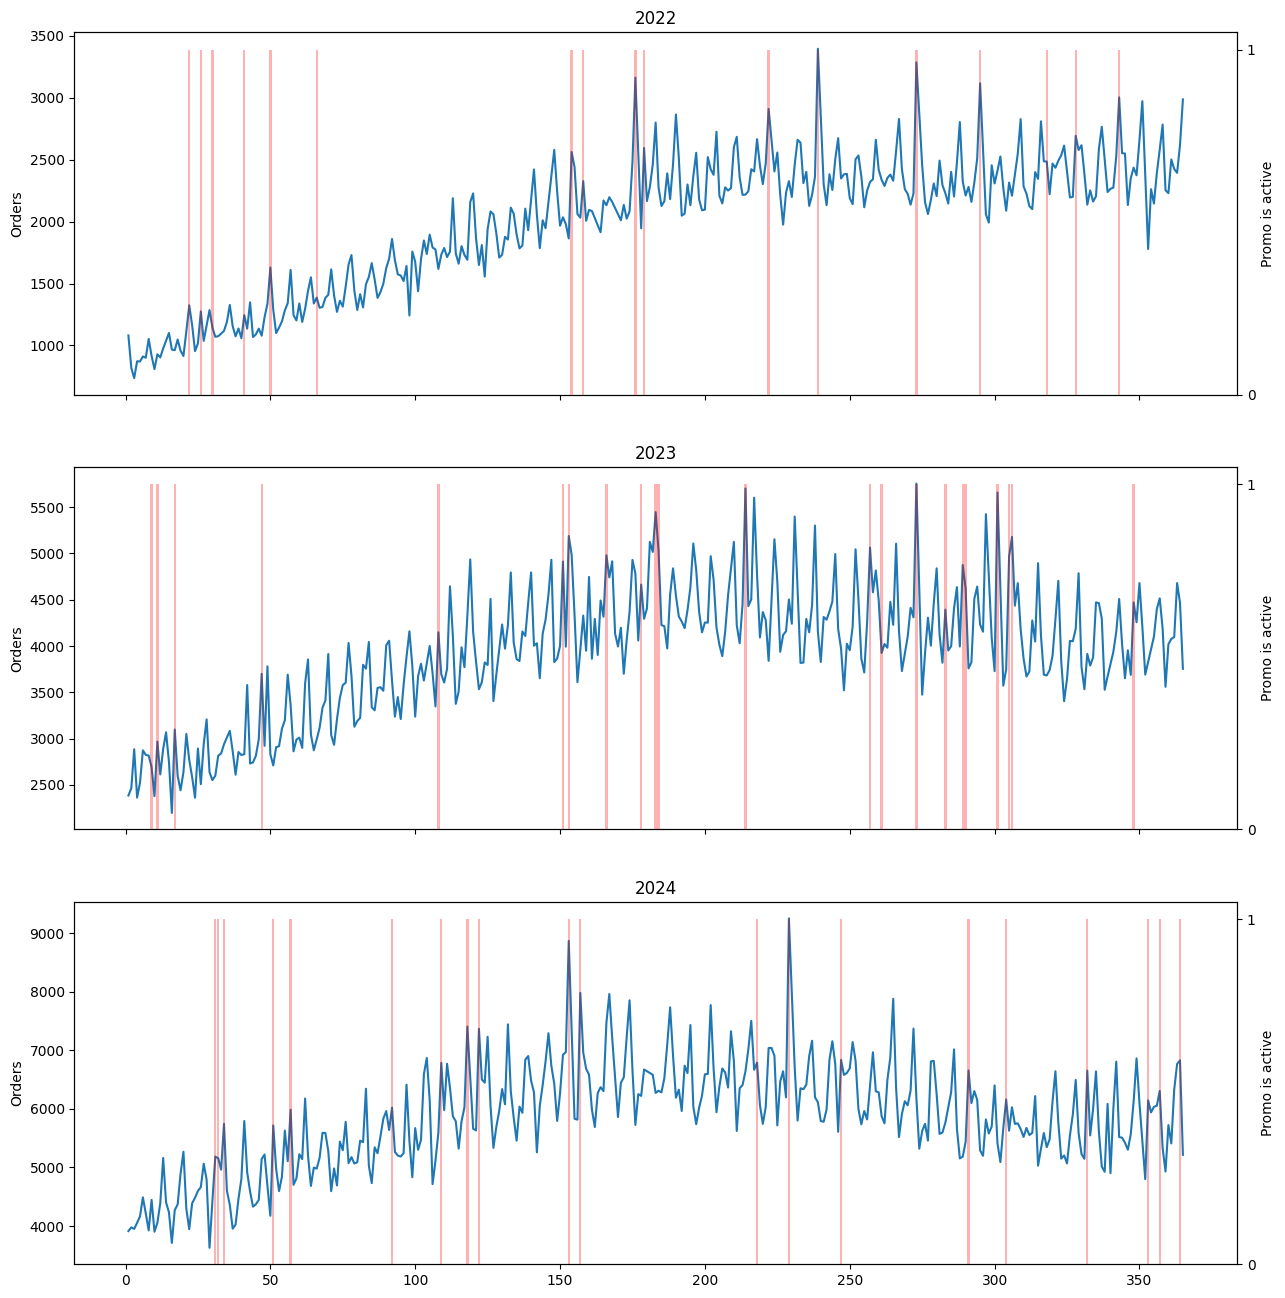

In [72]:
index_to_drop = df[(df['is_outlier_orders'] == True) & (df['is_promo_active'] == 0)].index


fig, axes = plt.subplots(3, 1, figsize=(15, 16), sharex=True)

df_cleared = df.drop(index_to_drop)

for i, year in enumerate(years):
    ax = axes[i]
    sub = df_cleared[(df_cleared.year == year)]
    
    ax.plot(
        sub.day_of_year,
        sub.orders,
    )
    ax.set_title(year)
    ax.set_ylabel('Orders')
    
    ax2 = ax.twinx()
    ax2.bar(
        sub.day_of_year,
        sub.is_promo_active,
        alpha=0.3,
        color='red',
    )
    ax2.set_ylabel('Promo is active')
    ax2.set_yticks([0, 1])

plt.xlabel('День в году')
plt.show()

In [73]:
df.drop(index_to_drop, inplace=True)

## Посмотрим, как себя показывают данные по дням недели

<Axes: xlabel='day_of_week', ylabel='orders'>

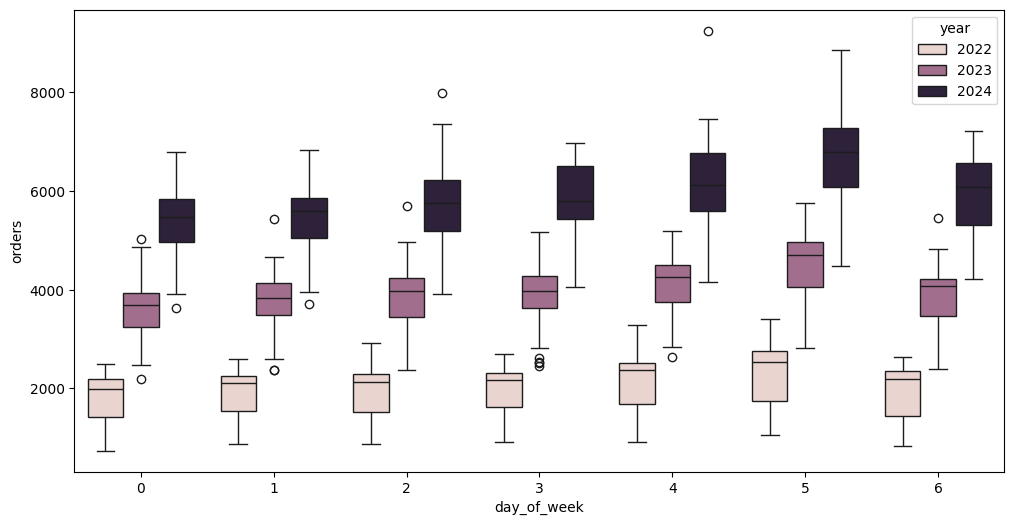

In [74]:
plt.figure(figsize=(12, 6))

sns.boxplot(
    data=df,
    x='day_of_week',
    y='orders',
    hue='year'
)

In [75]:
def mark_outlier(x, col):
    q1 = x[col].quantile(0.25)
    q3 = x[col].quantile(0.75)
    iqr = q3 - q1
    
    mark = (
        (x[col] < q1 - 1.5 * iqr) |
        (x[col] > q3 + 1.5 * iqr)
    )
    
    return mark

df['weekday_outlier'] = df.groupby(['year', 'day_of_week']).apply(lambda x: mark_outlier(x, 'orders')).reset_index(level=[0, 1], drop=True)

/tmp/ipykernel_3570/2264369910.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['weekday_outlier'] = df.groupby(['year', 'day_of_week']).apply(lambda x: mark_outlier(x, 'orders')).reset_index(level=[0, 1], drop=True)


In [76]:
pd.crosstab(df['is_promo_active'], df['weekday_outlier'])

weekday_outlier,False,True
is_promo_active,,
0,994,11
1,54,5


In [78]:
index_to_drop = df[(df['weekday_outlier'] == True) & (df['is_promo_active'] == 0)].index
df.drop(index_to_drop, inplace=True)

In [81]:
df[(df['weekday_outlier'] == True) & (df['is_promo_active'] == 1)]

,date,gmv,orders,sessions,marketing_spend,is_promo_active,day_of_week,day_of_year,week_of_year,month,year,is_outlier,is_outlier_orders,weekday_outlier
547,2023-07-02,1373082,5445,177878,89884,1,6,183,26,7,2023,False,False,True
548,2023-07-03,1042240,5028,149847,52627,1,0,184,27,7,2023,False,False,True
578,2023-08-02,1324478,5700,181304,71829,1,2,214,31,8,2023,False,False,True
886,2024-06-05,1400127,7981,238452,76210,1,2,157,23,6,2024,False,True,True
958,2024-08-16,1465886,9253,285952,85110,1,4,229,33,8,2024,False,True,True


## Из подозрительных только выброс под номером 578, но в этот день было также заметное падение маркетинга, поэтому эту строку тоже можем не удалять

In [83]:
df.drop(columns=['is_outlier', 'is_outlier_orders', 'weekday_outlier'], inplace=True)

In [84]:
df

,date,gmv,orders,sessions,marketing_spend,is_promo_active,day_of_week,day_of_year,week_of_year,month,year
0,2022-01-01,506994,1081,34861,25148,0,5,1,52,1,2022
1,2022-01-02,445834,819,32858,23769,0,6,2,52,1,2022
2,2022-01-03,348150,736,23081,22108,0,0,3,1,1,2022
3,2022-01-04,359418,872,25166,21757,0,1,4,1,1,2022
4,2022-01-05,381439,871,31082,21420,0,2,5,1,1,2022
...,...,...,...,...,...,...,...,...,...,...,...
1090,2024-12-26,891794,5410,171515,54332,0,3,361,52,12,2024
1091,2024-12-27,1011484,6330,219724,55346,0,4,362,52,12,2024
1092,2024-12-28,1064332,6767,229631,56839,0,5,363,52,12,2024
1093,2024-12-29,1150266,6829,223812,75393,1,6,364,52,12,2024


## Перейдём к feature engineering.

In [113]:
df.set_index('date', inplace=True)

## Влияют ли праздники на количество заказов и gmv?

<Axes: xlabel='month', ylabel='orders'>

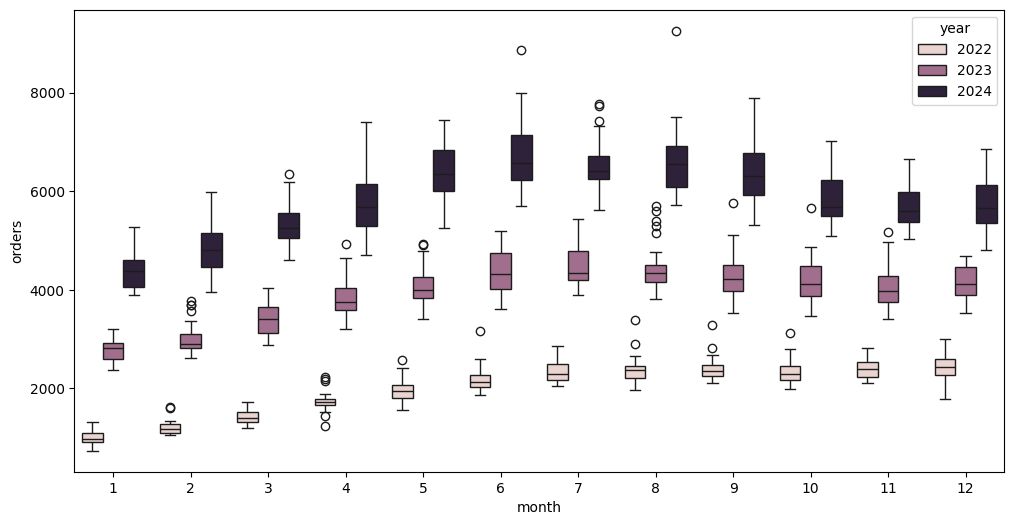

In [101]:
plt.figure(figsize=(12, 6))

sns.boxplot(
    data=df,
    x='month',
    y='orders',
    hue='year'
)

<Axes: xlabel='month', ylabel='gmv'>

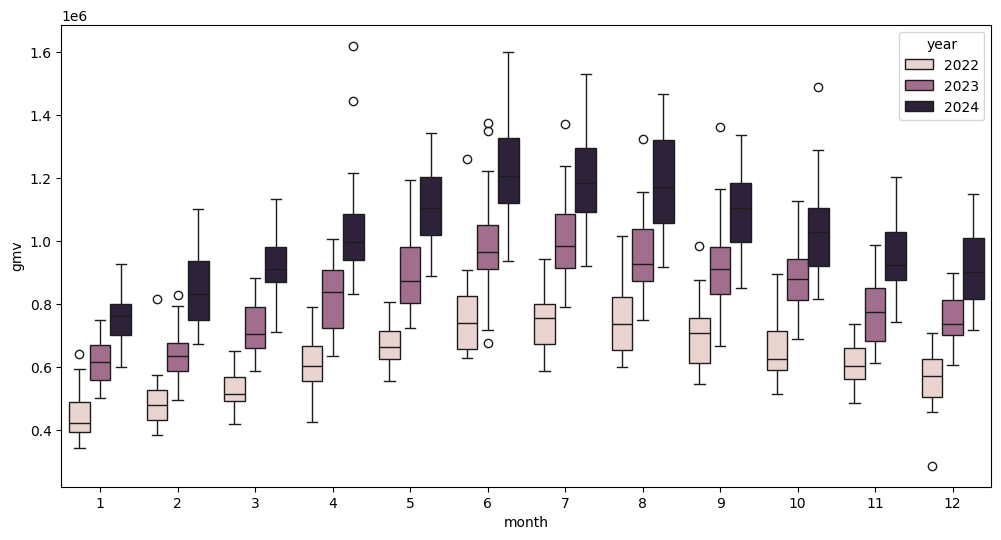

In [102]:
plt.figure(figsize=(12, 6))

sns.boxplot(
    data=df,
    x='month',
    y='gmv',
    hue='year'
)

## Спад gmv немного амортизируется, а количество заказов даже чуть вырастает

In [117]:
import holidays

ru_holidays = holidays.Russia(years=[2022, 2023, 2024])
df['is_holiday'] = df.index.isin(ru_holidays.keys())

/tmp/ipykernel_3570/1224109800.py:4: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df['is_holiday'] = df.index.isin(ru_holidays.keys())


## Для модели будет лучше подавать месяцы в цикличном виде, чтобы она понимала, что за декабрём сразу идёт январь

In [ ]:
df['month_cos'] = np.cos(2 * np.pi * (df['month'] - 1) / 12)

In [121]:
df['day_of_month'] = df.index.day

## Добавим столбец с инфой о предудщих днях

In [122]:
lags = [1, 2, 3, 7, 14, 30]

for lag in lags:
    df[f'gmv_lag {lag}'] = df['gmv'].shift(lag)
    df[f'orders_lag {lag}'] = df['orders'].shift(lag)

## Добавим скользящие окна для выявления 7-дневных паттернов

In [123]:
df['gmv_window_mean'] = df['gmv'].rolling(window=7).mean().shift(1)
df['gmv_window_std'] = df['gmv'].rolling(window=7).std().shift(1)

df['orders_window_mean'] = df['orders'].rolling(window=7).mean().shift(1)
df['orders_window_std'] = df['orders'].rolling(window=7).std().shift(1)

## Добавим признаки, отражающие скорость изменения тренда

In [125]:
df["gmv_diff_1"] = df["gmv"] - df["gmv"].shift(1)
df["gmv_diff_7"] = df["gmv"] - df["gmv"].shift(7)
df["orders_diff_1"] = df["orders"] - df["orders"].shift(1)
df["orders_diff_7"] = df["orders"] - df["orders"].shift(7)

## Надо заполнить пропуски, появившиеся от сдвигов

In [ ]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

cols = df.columns
index = df.index

scaler = StandardScaler()
scaled_df = scaler.fit_transform(df)

imputer = KNNImputer(weights='distance')
imputed_df = imputer.fit_transform(scaled_df)

df_result = scaler.inverse_transform(imputed_df)
df = pd.DataFrame(df_result, columns=cols, index=index)
df

,gmv,orders,sessions,marketing_spend,is_promo_active,day_of_week,day_of_year,week_of_year,month,year,...,gmv_lag 30,orders_lag 30,gmv_window_mean,gmv_window_std,orders_window_mean,orders_window_std,gmv_diff_1,gmv_diff_7,orders_diff_1,orders_diff_7
date,,,,,,,,,,,,,,,,,,,,,
2022-01-01,506994.0,1081.0,34861.0,25148.0,0.0,5.0,1.0,52.0,1.0,2022.0,...,5.719579e+05,2022.676172,547822.645457,70831.912234,1938.200976,203.691337,-29299.774063,6747.768579,-231.450237,27.074456
2022-01-02,445834.0,819.0,32858.0,23769.0,0.0,6.0,2.0,52.0,1.0,2022.0,...,5.316827e+05,1714.421994,547097.180229,71182.808958,1907.384295,200.559685,-61160.000000,7322.377615,-262.000000,20.007329
2022-01-03,348150.0,736.0,23081.0,22108.0,0.0,0.0,3.0,1.0,1.0,2022.0,...,5.388916e+05,1670.766697,521714.085362,80824.899179,1683.121927,172.644627,-97684.000000,31227.601450,-83.000000,42.158969
2022-01-04,359418.0,872.0,25166.0,21757.0,0.0,1.0,4.0,1.0,1.0,2022.0,...,5.307711e+05,1626.564878,518140.142521,83203.192831,1499.210581,165.892742,11268.000000,34571.207150,136.000000,50.152728
2022-01-05,381439.0,871.0,31082.0,21420.0,0.0,2.0,5.0,1.0,1.0,2022.0,...,5.048696e+05,1698.946964,505966.223058,81844.534636,1540.755828,164.760033,22021.000000,30252.656667,-1.000000,35.853039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-26,891794.0,5410.0,171515.0,54332.0,0.0,3.0,361.0,52.0,12.0,2024.0,...,8.231190e+05,5148.000000,908619.857143,130793.439582,5760.428571,477.287075,78473.000000,-12492.000000,-313.000000,-530.000000
2024-12-27,1011484.0,6330.0,219724.0,55346.0,0.0,4.0,362.0,52.0,12.0,2024.0,...,1.144627e+06,6654.000000,906835.285714,130947.557767,5684.714286,486.011562,119690.000000,94393.000000,920.000000,294.000000
2024-12-28,1064332.0,6767.0,229631.0,56839.0,0.0,5.0,363.0,52.0,12.0,2024.0,...,8.754780e+05,5547.000000,920320.000000,136904.399979,5726.714286,531.959809,52848.000000,-723.000000,437.000000,713.000000


## Выберем и обучим модель